In [1]:
direc="/home/qwe/Desktop/code/dtp_outcome_mesures/liveshow_case/client.log"

# API用例说明
## 对于data_process模块中每个API使用方法进行演示
### 1.结果读写和解析
### 2.配置读取和生成
### 3.其他工具

In [29]:
import sys
sys.path.append('./dtp_outcome_mesures')
import data_process.py

In [82]:
MAX_BLOCK_SIZE = 1000000 # 1Mbytes
tmp_dir_path='.'
CLIENT_LOG_PATTERN = re.compile(r'connection closed\nrecv=(-?\d+) sent=(-?\d+) lost=(-?\d+) rtt=(?:(?:(\d|.+)ms)|(?:(-1))) cwnd=(-?\d+), total_bytes=(-?\d+), complete_bytes=(-?\d+), good_bytes=(-?\d+), total_time=(-?\d+)')
CLIENT_STAT_INDEXES = ["c_recv", "c_sent", "c_lost", "c_rtt(ms)", "c_cwnd", "c_total_bytes", "c_complete_bytes", "c_good_bytes", "c_total_time(us)", "qoe", "retry_times"]
CLIENT_BLOCKS_INDEXES = ["BlockID", "bct", "BlockSize", "Priority", "Deadline"]

## 结果读写和解析

## 画图

In [130]:
def drawGraph(axisX,axisYList,labelNameList,interval=0):
    '''
    axisX:list,usually time
    axisYList:list[],each element is a type of axisY.
    interval: used for live show
    '''
    
    plt.clf()

    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f %%'))
    plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1fs'))
    plt.xlabel('time')
    plt.ylabel('rate')
    plt.title('DTP live show')
    for i in range(len(axisYList)):
        plt.plot(axisX,axisYList[i],label=labelNameList[i])

    plt.legend()
    if interval !=0:
        plt.pause(interval)

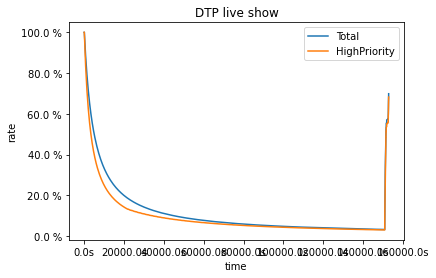

In [131]:
drawGraph(X,[Y1,Y2],['Total','HighPriority'])

# 读取输出日志信息
### 1. 输入服务端日志server_err.log、发送块信息block_trace、客户端日志client.log路径。
### 2.输出高优先级块按时完成率等信息
### 3.draw=true时，画出图像，默认Y轴为高优先级块完成率和所有块按时完成率


In [132]:
def calculate_statiscs(servErrPath,blockConfPath,logPath='./client.log',draw=False):
    """
    Parse the content tn the Client.log,return a dict contains the statistics of the outcome mesures.
    keys:
    'TotalBlockNum':Number of blocks planning to send by the server.
    'BlockSentNum':Number of blocks sent by the server.
    'BlockRecvNum':Number of blocks recieved by the client
    'BlockInTime':Number of blocks arrived before the ddl.
    'HighpriBlockInTime':the number of high priority blocks arrived before the ddl.
    'AvrTime':Average BCT(ms)

    if parameter draw set to True,Draw a picture with y value as block-in-time rate and x value as time.
    """
    logStart='BlockID  bct  BlockSize  Priority  Deadline\n'
    
    # collect client blocks information
    client_blocks_dict = {}
    for index in CLIENT_BLOCKS_INDEXES:
        client_blocks_dict[index] = []
    # collect client stats
    client_stat_dict = {}
    for index in CLIENT_STAT_INDEXES:
        client_stat_dict[index] = []
        
    if os.path.isfile(logPath)==False:
        print("Error calculate_statiscs:clint.log not found")
        return
    flag=True
    
    lineNum=4 #offset
    resDict={}
   #读头
    line=linecache.getline(logPath,lineNum)
    if line==logStart:
        lineNum+=1
    else:
        print("Error calculate_statiscs:incomplete clitnt.log")
        return

    #analysing
    
    endFlagstr='connection closed\n'
    sendBlockNum=len(open(blockConfPath,'r').readlines()) #发送块数

    totalBct=0      #总发送时间
    highPriNum=0  #高优先级块数
    highPri_late=0  #超时到达高优先级块数
    total_late =0   #超时块数
    recvBlockNum=0        #总接收块
    flag=True

    #drawing
    timeX=[]
    high_rateY=[]
    rateY=[]
    avrTimeY=[]
    curTime=0

    while flag:
        changeFlag=False#output when new lines arrive

        _=linecache.updatecache(logPath)
        blank=False
        while blank!=True:
            line=linecache.getline(logPath,lineNum)
            if line=='':
                print("Error calculate_statiscs:incomplete clitnt.log")
                return
            elif line==endFlagstr:
                blank=True
                flag=False
            else:#parse
                p=re.findall(r'\b\d+\b',line)
                p=list(map(int,p))
                if len(p)!=5:
                    break#ramdom bug
                changeFlag=True
                recvBlockNum+=1
                bct=p[1]
                totalBct+=bct
                lineNum+=1
                if p[3]==1:
                    highPriNum+=1
                if bct>p[4]:
                    total_late+=1
                    if p[3]==1:
                        highPri_late +=1
                        
                if draw == True:
                    curTime+=bct
                    timeX.append(curTime)
                    highBlockRate=round(100*(highPriNum-highPri_late)/highPriNum,2)
                    high_rateY.append(highBlockRate)
                    blockRate=round((recvBlockNum-total_late)/recvBlockNum*100,2)
                    rateY.append(blockRate)
                    
        #continue
        if changeFlag==True and draw ==True:
            #print('已接收{}块，平均完成时间为{}s,高优先级块按时完成率为{}%,所有块按时完成率为{}%'.format(recvBlockNum,round(totalBct/recvBlockNum,2),100*(highPriNum-highPri_late)/highPriNum,(recvBlockNum-total_late)/sendBlockNum*100))
            avrTime=round(totalBct/recvBlockNum,2)
            highBlockRate=round(100*(highPriNum-highPri_late)/highPriNum,2)
            blockRate=round((recvBlockNum-total_late)/recvBlockNum*100,2)

            timeX.append(curTime)
            high_rateY.append(highBlockRate)
            rateY.append(blockRate)
            #draw
            drawGraph(timeX,[rateY,high_rateY],['Total','HighPriority'])
            
            print('已接收{}块，平均完成时间为{}ms,高优先级块按时完成率为{}%'.format(recvBlockNum,avrTime,highBlockRate))
       #blocks num lines of blocks


    
    #logs_Path=resultPath+'/logs'

    blockDropNum=0
    servErrLog=open(servErrPath)
    for line in servErrLog:
        if line!='' and line[0]=='b' and line[1]=='l':
            blockDropNum +=1
    blockSentNum=sendBlockNum-blockDropNum
    
    
    resDict={'TotalBlockNum':sendBlockNum,'BlockSentNum':blockSentNum,'BlockRecvNum':recvBlockNum,'BlockInTime':recvBlockNum-total_late,'HighpriBlockInTime':highPriNum-highPri_late,'AvrTime':round(totalBct/recvBlockNum,2)}

    return resDict,timeX,rateY,high_rateY

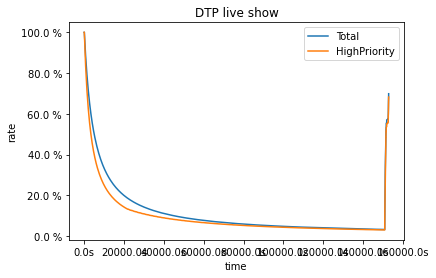

已接收1508块，平均完成时间为101.36ms,高优先级块按时完成率为68.2%
{'TotalBlockNum': 5, 'BlockSentNum': 2, 'BlockRecvNum': 1508, 'BlockInTime': 1053, 'HighpriBlockInTime': 697, 'AvrTime': 101.36}


In [137]:
resDict,X,Y1,Y2=calculate_statiscs(logPath='./client.log',blockConfPath='./aitrans_block.txt',
                           servErrPath='./server_err.log',draw=True)
print(resDict)

# 读取输出日志信息2


In [144]:
def parse_client_log(dir_path):
    '''
    Parse client.log and get two dicts of information.
    `client_blocks_dict` stores information in client.log about block's stream_id, bct, deadline and priority
    `client_stat_dict` stores statistics offered in client.log. Some important information is like goodbytes and total running time(total time)
    '''
    # collect client blocks information
    client_blocks_dict = {}
    for index in CLIENT_BLOCKS_INDEXES:
        client_blocks_dict[index] = []
    # collect client stats
    client_stat_dict = {}
    for index in CLIENT_STAT_INDEXES:
        client_stat_dict[index] = []

    with open(os.path.join(dir_path, "client.log")) as client:
        client_lines = client.readlines()

        for line in client_lines[4:-1]:
            if len(line) > 1:
               client_line_list = line.split()
               if len(client_line_list) != len(CLIENT_BLOCKS_INDEXES):
                   print("A client block log line has error format in : %s. This happens sometime." % dir_path)
                   continue
               for i in range(len(client_line_list)):
                   client_blocks_dict[CLIENT_BLOCKS_INDEXES[i]].append(client_line_list[i])

        # try to parse the last line of client log
        try:
            lastLine=client_lines[-1][0:-1].split(',')
            print(lastLine)
            if len(lastLine)!=9:
                raise ValueError("client re match returns None in : %s" % dir_path, client_lines[-1])

            client_stat_dict["c_recv"].append(float(lastLine[0]))
            client_stat_dict["c_sent"].append(float(lastLine[1]))
            client_stat_dict["c_lost"].append(float(lastLine[2]))
            client_stat_dict["c_rtt(ms)"].append(float(lastLine[3]))


            client_stat_dict["c_cwnd"].append(float(lastLine[4]))
            client_stat_dict["c_total_bytes"].append(float(lastLine[5]))
            client_stat_dict["c_complete_bytes"].append(float(lastLine[6]))
            client_stat_dict["c_good_bytes"].append(float(lastLine[7]))
            client_stat_dict["c_total_time(us)"].append(float(lastLine[8]))

            # invalid stat
            client_stat_dict["qoe"].append(-1)
            client_stat_dict["retry_times"].append(-1)

            return client_blocks_dict, client_stat_dict

        except Exception:
            print(dir_path)
            print(client_lines[-1])
            raise ValueError("Could not parse client's last line")

In [145]:
client_blocks_dict, client_stat_dict=parse_client_log('.')
print( client_stat_dict,client_blocks_dict)

A client block log line has error format in : .. This happens sometime.
A client block log line has error format in : .. This happens sometime.
['22656', '8966', '0', '3.035950', '14520', '29244304', '27882925', '27882925', '19514950']
{'c_recv': [22656.0], 'c_sent': [8966.0], 'c_lost': [0.0], 'c_rtt(ms)': [3.03595], 'c_cwnd': [14520.0], 'c_total_bytes': [29244304.0], 'c_complete_bytes': [27882925.0], 'c_good_bytes': [27882925.0], 'c_total_time(us)': [19514950.0], 'qoe': [-1], 'retry_times': [-1]} {'BlockID': ['5', '9', '13', '17', '21', '25', '29', '33', '37', '41', '45', '49', '53', '57', '89', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '61', '65', 

## 读取aitrans_block.txt

# 写结果

In [ ]:
#def writeToLog(form,logPath,args:list):
    """
    for the client.write the log
    form:
    1:
    2:
    3:
    args:
    as for 1:
    as for 2:
    as for 3:
    """
#    with open(os.path.join(tmp_dir_path, 'aitrans_block.txt'), 'a') as f:
#        f.write('%f    %d    %d    %d\n' % (block_gap * i, 2147483647, block_size, 0))

# 配置读取和生成

## 生成发送块配置
## 需要config.json文件
[
    {	"dir_name":"test1",
	    "image_name":"dtptest",

	 "block_trace":"./aitrans_block.txt",
        "network_trace":"./net_trace/trace_7.txt",
	        "block_size": 50,
        "block_num": 5,
        "redundancy": 0.0,
        "cc": ["reno"],
        "bw": 100,
        "rtt": 40,
        "loss": 0
    }
]

In [74]:
def generate_block_file(config: dict):
    '''
    generate block file with the config
    '''

    block_size = min(int(config['block_size']), MAX_BLOCK_SIZE)
    if block_size <= 0:
        block_size = MAX_DATAGRAM_SIZE
    block_num = int(config['block_num'])
    block_gap = 0.001
    if config.get("block_gap"):
       block_gap = int(config["block_gap"])
    with open(os.path.join(tmp_dir_path, 'aitrans_block.txt'), 'w') as f:
        for i in range(block_num):
            f.write('%f    %d    %d    %d\n' % (block_gap * i, 2147483647, block_size, 0))

In [76]:
def generate_consistent_network_file(config):
    '''
    generate consistent network trace
    example: 0, 1, 0.00001, 0.1 # @0 second, 1Mbps, loss rate=0.00001, 100ms latency
    '''
    with open(os.path.join(tmp_dir_path, 'traces.txt'), 'w') as f:
        f.write('%d, %f, %f, %f' % (0, float(config['bw']), float(config['loss']), float(config['rtt']) / 2 / 1000))

In [65]:
def parse_config(filepath: str):
    '''
    Parse the given config file and return the json obj
    '''
    with open(filepath, 'r') as f:
        return json.load(f)[0]

In [143]:
conf=parse_config('./config.json')
print(conf,end='\n\n')
generate_block_file(conf)
os.system("head aitrans_block.txt")

{'dir_name': 'test1', 'image_name': 'dtptest', 'block_trace': './aitrans_block.txt', 'network_trace': './net_trace/trace_7.txt', 'block_size': 50, 'block_num': 5, 'redundancy': 0.0, 'cc': ['reno'], 'bw': 100, 'rtt': 40, 'loss': 0}

0.000000    2147483647    50    0
0.001000    2147483647    50    0
0.002000    2147483647    50    0
0.003000    2147483647    50    0
0.004000    2147483647    50    0


0

In [121]:
def generate_consistent_network_file(config):
    '''
    generate consistent network trace
    example: 0, 1, 0.00001, 0.1 # @0 second, 1Mbps, loss rate=0.00001, 100ms latency
    '''
    with open(os.path.join(tmp_dir_path, 'traces.txt'), 'w') as f:
        f.write('%d, %f, %f, %f' % (0, float(config['bw']), float(config['loss']), float(config['rtt']) / 2 / 1000))

def generate_redundancy_code_file(config):
    with open(os.path.join(tmp_dir_path, 'redundant.cpp'), 'w') as f:
        f.write( \
            '''
            #include "solution.hxx"
            float global_redundancy = {0};
            '''.format(max(0.0, float(config['redundancy']))) \
        )